In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add, Dropout
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

DATA_PATH = "/content/drive/MyDrive/data.json"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test
    #return X_train, X_test, y_train, y_test

In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]
        #self.dropout = dropout
        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "glorot_uniform"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.drop_1 = Dropout(0.3)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.drop_2 = Dropout(0.3)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_drop = Dropout(0.3)
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.drop_1(x)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.drop_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_drop(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="glorot_uniform")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out


In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    #X_train, X_test, y_train,  y_test = prepare_datasets(0.25)
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)









In [ ]:
X_train.shape


(5991, 130, 13, 1)

In [ ]:
X_validation.shape

(1498, 130, 13, 1)

In [ ]:
X_test.shape

(2497, 130, 13, 1)

In [ ]:
model = ResNet18(10)
model.build(input_shape = (None,X_train.shape[1], X_train.shape[2], 1))
# create network
#input_shape = (X_train.shape[1], X_train.shape[2], 1)
#model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple                  74368     
 k)                                                              
                                                         

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15
)

Epoch 1/100
188/188 [==============================] - 24s 38ms/step - loss: 2.0932 - accuracy: 0.2492 - val_loss: 3.3220 - val_accuracy: 0.1482
Epoch 2/100
188/188 [==============================] - 5s 25ms/step - loss: 1.7368 - accuracy: 0.3696 - val_loss: 4.9220 - val_accuracy: 0.1709
Epoch 3/100
188/188 [==============================] - 5s 28ms/step - loss: 1.5292 - accuracy: 0.4358 - val_loss: 3.5882 - val_accuracy: 0.2430
Epoch 4/100
188/188 [==============================] - 5s 25ms/step - loss: 1.4052 - accuracy: 0.4794 - val_loss: 3.0551 - val_accuracy: 0.2770
Epoch 5/100
188/188 [==============================] - 5s 25ms/step - loss: 1.3168 - accuracy: 0.5093 - val_loss: 2.6910 - val_accuracy: 0.3171
Epoch 6/100
188/188 [==============================] - 5s 28ms/step - loss: 1.2597 - accuracy: 0.5507 - val_loss: 2.4892 - val_accuracy: 0.3364
Epoch 7/100
188/188 [==============================] - 5s 26ms/step - loss: 1.1919 - accuracy: 0.5598 - val_loss: 2.2404 - val_accuracy

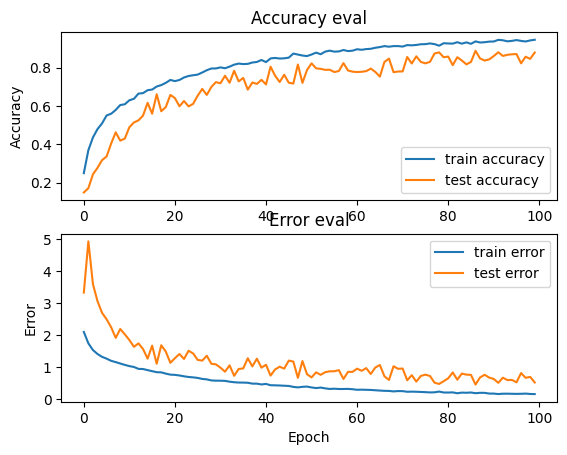

In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100,callbacks=[callback])

# plot accuracy/error for training and validation
plot_history(history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 1s - loss: 0.6232 - accuracy: 0.8646 - 833ms/epoch - 11ms/step

Test accuracy: 0.864637553691864


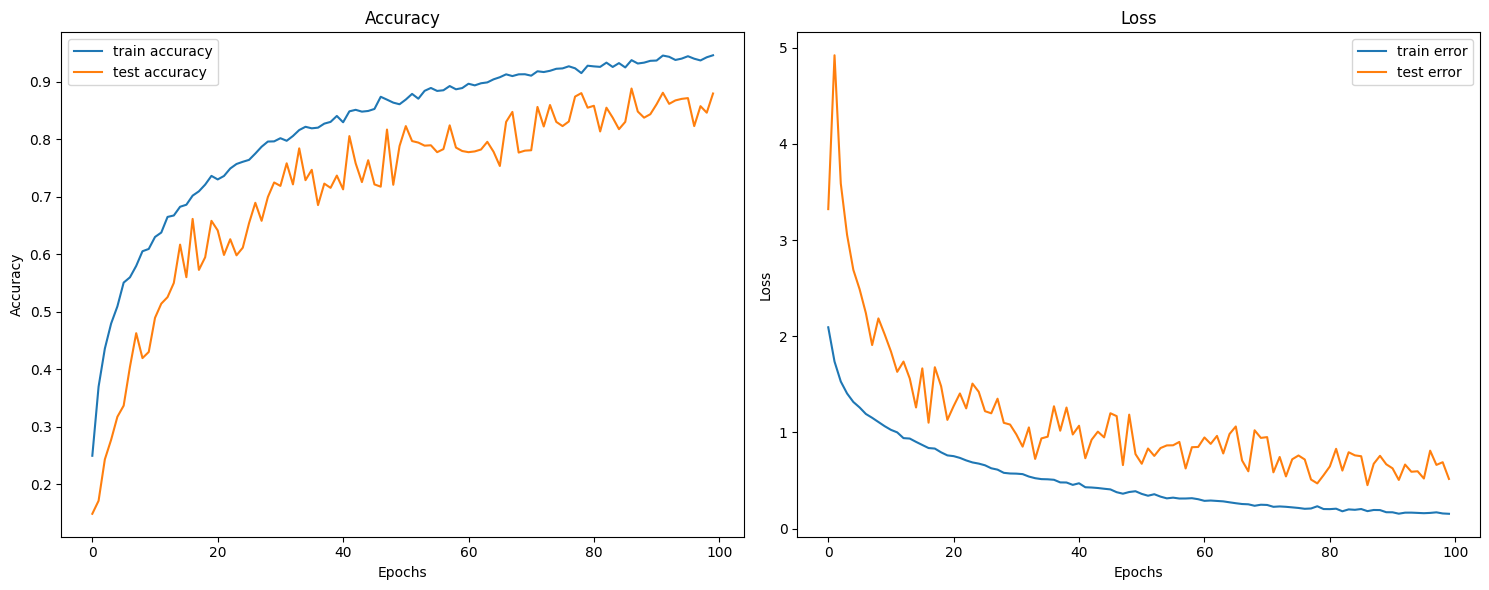

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train error')
plt.plot(history.history['val_loss'], label='test error')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.623 and val_acc = 0.865


In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[61]
y_to_predict = y_test[61]

# predict sample
predict(model, X_to_predict, y_to_predict)

1/1 [==============================] - 0s 382ms/step
Target: 1, Predicted label: [1]


In [ ]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import itertools


In [ ]:
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [ ]:
y_test

array([7, 0, 1, ..., 1, 1, 5])

In [ ]:
y = model.predict(X_test)
y

79/79 [==============================] - 0s 5ms/step


array([[2.0502537e-09, 5.7612155e-11, 3.2506775e-06, ..., 9.9991238e-01,
        2.0968663e-12, 2.5293712e-08],
       [9.9997330e-01, 3.4364964e-09, 1.9382173e-06, ..., 1.4407441e-08,
        3.3369790e-07, 1.9437828e-05],
       [2.0381266e-09, 9.9999380e-01, 1.6525672e-12, ..., 2.4562709e-16,
        1.0102857e-06, 3.2381231e-06],
       ...,
       [4.6017765e-10, 9.9998879e-01, 7.4736672e-10, ..., 6.0023722e-11,
        7.8019657e-06, 1.1249823e-08],
       [1.2107226e-09, 9.9994159e-01, 2.1276149e-08, ..., 1.2653469e-08,
        1.0022862e-06, 1.4910575e-05],
       [1.3298936e-04, 2.0803472e-03, 3.0214803e-08, ..., 8.4313162e-10,
        8.1117627e-11, 5.5689799e-07]], dtype=float32)

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = y_test
cm = confusion_matrix(preds, y_orig)

79/79 [==============================] - 0s 5ms/step


Confusion matrix, without normalization


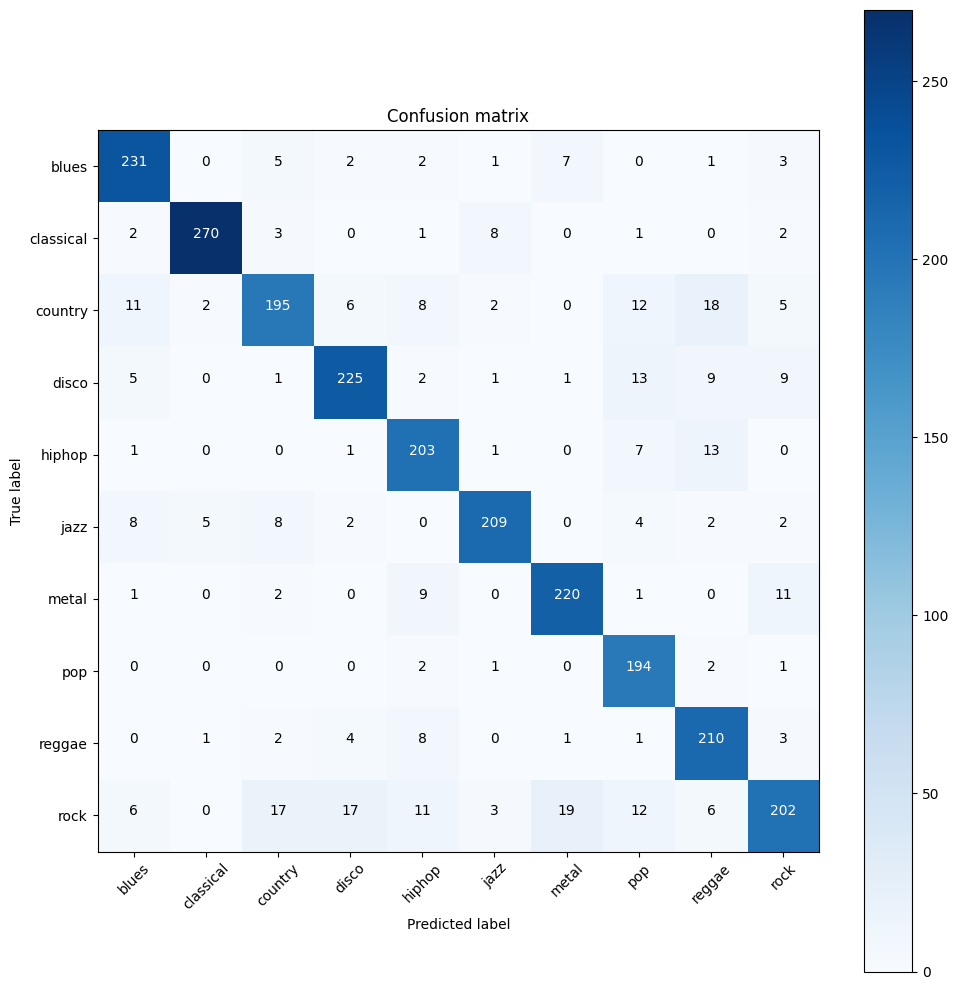

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_orig, preds, target_names=genres))

              precision    recall  f1-score   support

       blues       0.92      0.87      0.89       265
   classical       0.94      0.97      0.96       278
     country       0.75      0.84      0.79       233
       disco       0.85      0.88      0.86       257
      hiphop       0.90      0.83      0.86       246
        jazz       0.87      0.92      0.90       226
       metal       0.90      0.89      0.89       248
         pop       0.97      0.79      0.87       245
      reggae       0.91      0.80      0.86       261
        rock       0.69      0.85      0.76       238

    accuracy                           0.86      2497
   macro avg       0.87      0.86      0.86      2497
weighted avg       0.87      0.86      0.87      2497

